
# Bees Algorithm (BA) for 0–1 Knapsack — All-in-One Notebook

This notebook contains:
- Parsers for common datasets (Burkardt, OR-Library WEING*, Pisinger knapPI_*, simple CSV).
- BA solver with feasibility repair and statistics tracking.
- Greedy and DP-exact baselines.
- Reproducible single-run and batch-run helpers.
- Plotting utilities for convergence.


In [1]:
# Core
import numpy as np
import random
from dataclasses import dataclass
import dataclasses  # for dataclasses.replace(...)
from typing import List, Tuple, Dict, Optional
import time
import math
import pathlib
import json

# Viz + IO
import matplotlib.pyplot as plt
import pandas as pd


In [2]:
def set_seed(seed: int):
    np.random.seed(seed)
    random.seed(seed)


## Parsers

In [3]:
from dataclasses import dataclass
from typing import Optional, List, Dict, Any, Tuple
import pathlib
import numpy as np
import pandas as pd
import re

# -------------------------------------------------------------------
# Core data structure
# -------------------------------------------------------------------
@dataclass
class KnapsackInstance:
    name: str
    n: int
    W: int
    values: np.ndarray  # shape (n,)
    weights: np.ndarray # shape (n,)

# -------------------------------------------------------------------
# OR-Library (weing*/weish*) multi-instance loader — robust, line-based
# -------------------------------------------------------------------
def parse_weing_multi(path: str) -> List[KnapsackInstance]:
    """
    Robust parser for OR-Library weing/weish knapsack files.

    Layout:
        <num_instances> <n_items>
        values for instance 1  (wraps across lines)
        weights for instance 1 (wraps across lines)
        capacity 1             (single integer line)
        [blank lines allowed]
        values for instance 2
        weights for instance 2
        capacity 2
        ...
    """
    p = pathlib.Path(path)
    raw_lines = p.read_text().splitlines()
    # keep empties; we’ll skip them selectively
    lines = [ln.rstrip() for ln in raw_lines]

    def next_nonempty(idx: int) -> Tuple[Optional[str], int]:
        while idx < len(lines) and not lines[idx].strip():
            idx += 1
        if idx >= len(lines):
            return None, idx
        return lines[idx].strip(), idx

    # header: "<num_sets> <n>"
    i = 0
    head, i = next_nonempty(i)
    if head is None:
        return []
    parts = head.split()
    if len(parts) < 2:
        raise ValueError(f"{p.name}: bad header line: '{head}'")
    num_sets, n = map(int, parts[:2])
    i += 1

    out: List[KnapsackInstance] = []
    for set_idx in range(num_sets):
        # ---- collect n values
        vals: List[int] = []
        while len(vals) < n:
            line, i = next_nonempty(i)
            if line is None:
                if set_idx == 0:
                    raise ValueError(f"{p.name}: incomplete file, missing values for instance 1")
                print(f"⚠️  Warning: {p.name} only contains {set_idx} valid instance(s).")
                return out
            try:
                vals.extend(map(int, line.split()))
            except ValueError:
                raise ValueError(f"{p.name}: non-integer token in values (inst {set_idx+1}): '{line}'")
            i += 1
        vals = vals[:n]

        # ---- collect n weights
        wts: List[int] = []
        while len(wts) < n:
            line, i = next_nonempty(i)
            if line is None:
                if set_idx == 0:
                    raise ValueError(f"{p.name}: incomplete file, missing weights for instance 1")
                print(f"⚠️  Warning: {p.name} only contains {set_idx} valid instance(s).")
                return out
            try:
                wts.extend(map(int, line.split()))
            except ValueError:
                raise ValueError(f"{p.name}: non-integer token in weights (inst {set_idx+1}): '{line}'")
            i += 1
        wts = wts[:n]

        # ---- capacity = first next non-empty line with EXACTLY ONE integer
        while True:
            cap_line, i_cap = next_nonempty(i)
            if cap_line is None:
                raise ValueError(f"{p.name}: missing capacity for instance {set_idx+1}")
            toks = cap_line.split()
            # only accept capacity if it's a single integer token
            if len(toks) == 1 and toks[0].lstrip("-").isdigit():
                W = int(toks[0])
                i = i_cap + 1
                break
            else:
                # Not a capacity line; advance and keep looking
                i = i_cap + 1

        out.append(
            KnapsackInstance(
                name=f"{p.stem}_set{set_idx+1}",
                n=n,
                W=W,
                values=np.array(vals, dtype=int),
                weights=np.array(wts, dtype=int),
            )
        )

    return out

def load_weing_like(path: str, name: Optional[str] = None) -> KnapsackInstance:
    """Load the *first* instance from a multi-instance OR-Library file."""
    lst = parse_weing_multi(path)
    if not lst:
        raise ValueError(f"No instances found in {path}")
    inst = lst[0]
    if name:
        inst.name = name
    return inst

# -------------------------------------------------------------------
# Pisinger knapPI multi-instance text parser (your .csv files are text)
# -------------------------------------------------------------------
@dataclass
class PisingerMeta:
    name: str
    z_opt: Optional[int]
    opt_vector: Optional[np.ndarray]

def parse_knapPI_multi_text(path: str) -> List[Dict[str, Any]]:
    p = pathlib.Path(path)
    txt = p.read_text(encoding="utf-8").strip()
    raw_blocks = [b.strip() for b in re.split(r'-{3,}', txt) if b.strip()]
    out = []
    for block in raw_blocks:
        lines = [ln.strip() for ln in block.splitlines() if ln.strip()]
        if not lines:
            continue
        name = lines[0]
        params = {}
        i = 1
        while i < len(lines) and re.match(r'^(n|c|z|time)\b', lines[i]):
            k, v = lines[i].split()
            params[k] = v
            i += 1
        n = int(params["n"]); W = int(params["c"])
        z_opt = int(params["z"]) if "z" in params else None

        items = []
        for ln in lines[i:]:
            parts = [s.strip() for s in ln.split(',')]
            if len(parts) >= 3 and parts[0].isdigit():
                idx = int(parts[0]); val = int(parts[1]); wt = int(parts[2])
                opt = int(parts[3]) if len(parts) >= 4 and parts[3].isdigit() else 0
                items.append((idx, val, wt, opt))
        items.sort(key=lambda t: t[0])
        assert len(items) == n, f"{name}: expected {n} items, got {len(items)}"

        values  = np.array([t[1] for t in items], dtype=int)
        weights = np.array([t[2] for t in items], dtype=int)
        optvec  = np.array([t[3] for t in items], dtype=int)
        inst = KnapsackInstance(name=name, n=n, W=W, values=values, weights=weights)
        meta = PisingerMeta(name=name, z_opt=z_opt, opt_vector=optvec if len(optvec)==n else None)
        out.append({"instance": inst, "meta": meta})
    return out

def list_knapPI_instances(path: str) -> List[str]:
    return [e["instance"].name for e in parse_knapPI_multi_text(path)]

def load_knapPI_by_name_text(path: str, name: str) -> Tuple[KnapsackInstance, PisingerMeta]:
    for e in parse_knapPI_multi_text(path):
        if e["instance"].name == name:
            return e["instance"], e["meta"]
    raise ValueError(f"Instance '{name}' not found in {path}")

def load_knapPI_first_block(path: str) -> Tuple[KnapsackInstance, PisingerMeta]:
    lst = parse_knapPI_multi_text(path)
    if not lst:
        raise ValueError(f"No instances found in {path}")
    e = lst[0]
    return e["instance"], e["meta"]


## Bees Algorithm (BA)

In [4]:
def total_weight(x: np.ndarray, w: np.ndarray) -> int:
    return int(w @ x)

def total_value(x: np.ndarray, v: np.ndarray) -> int:
    return int(v @ x)

def is_feasible(x: np.ndarray, w: np.ndarray, W: int) -> bool:
    return total_weight(x, w) <= W

def greedy_drop_repair(x: np.ndarray, v: np.ndarray, w: np.ndarray, W: int) -> np.ndarray:
    """
    If overweight, drop items with worst 'value density' v/w first until feasible.
    """
    if is_feasible(x, w, W):
        return x.copy()
    x = x.copy()
    idx = np.where(x == 1)[0]
    # sort by ascending density (worst first)
    order = sorted(idx, key=lambda i: v[i]/w[i])
    for i in order:
        if total_weight(x, w) <= W:
            break
        x[i] = 0
    return x

def greedy_fill_repair(x: np.ndarray, v: np.ndarray, w: np.ndarray, W: int) -> np.ndarray:
    """
    If under capacity, try to add items with best value density that still fit.
    """
    x = x.copy()
    idx = np.where(x == 0)[0]
    order = sorted(idx, key=lambda i: v[i]/w[i], reverse=True)
    for i in order:
        if total_weight(x, w) + w[i] <= W:
            x[i] = 1
    return x

def repair(x: np.ndarray, v: np.ndarray, w: np.ndarray, W: int) -> np.ndarray:
    """Two-stage repair: drop then optional fill."""
    x = greedy_drop_repair(x, v, w, W)
    x = greedy_fill_repair(x, v, w, W)
    return x


## Baselines: Greedy & DP exact (optional)

In [5]:
def greedy_ratio(inst: KnapsackInstance) -> Tuple[np.ndarray, int, int]:
    order = np.argsort(-(inst.values / inst.weights))
    x = np.zeros(inst.n, dtype=int)
    cw = 0
    for i in order:
        if cw + inst.weights[i] <= inst.W:
            x[i] = 1
            cw += inst.weights[i]
    return x, total_value(x, inst.values), total_weight(x, inst.weights)


## Helpers: Single run, Batch run, and Plotting

In [6]:
def dp_knapsack(inst: KnapsackInstance) -> Tuple[np.ndarray, int, int]:
    """
    Classic O(n*W) DP; safe only for modest W.
    """
    n, W = inst.n, inst.W
    if W > 100000:  # guardrail to avoid memory blow-ups
        raise MemoryError("W too large for DP in this notebook (W > 100000).")
    dp = np.zeros(W+1, dtype=int)
    keep = np.zeros((n, W+1), dtype=bool)
    for i in range(n):
        w_i, v_i = inst.weights[i], inst.values[i]
        for c in range(W, w_i-1, -1):
            new = dp[c - w_i] + v_i
            if new > dp[c]:
                dp[c] = new
                keep[i, c] = True
    # reconstruct
    x = np.zeros(n, dtype=int)
    c = W
    for i in range(n-1, -1, -1):
        if keep[i, c]:
            x[i] = 1
            c -= inst.weights[i]
    return x, total_value(x, inst.values), total_weight(x, inst.weights)


## Quick sanity check on a tiny CSV dataset

In [7]:
@dataclass
class BAParams:
    n_scouts: int = 30            # total sites visited by scouts per iteration
    n_elite: int = 3              # number of elite sites
    n_best: int = 7               # number of best (non-elite) sites
    nre: int = 20                 # recruits per elite site
    nrb: int = 10                 # recruits per best site
    ngh_init: int = 3             # initial neighborhood radius (Hamming)
    ngh_min: int = 1              # minimum neighborhood radius
    ngh_shrink: float = 0.95      # multiplicative shrink when no improvement
    max_iters: int = 300
    stall_iters: int = 50
    seed: int = 42


In [8]:
def random_solution(n: int) -> np.ndarray:
    return np.random.randint(0, 2, size=n, dtype=int)

def neighborhood_sample(x: np.ndarray, ngh: int, samples: int) -> List[np.ndarray]:
    """
    Sample 'samples' neighbors by flipping k bits where k ~ U(1, ngh).
    """
    n = len(x)
    res = []
    for _ in range(samples):
        k = np.random.randint(1, ngh+1)
        idx = np.random.choice(n, size=k, replace=False)
        y = x.copy()
        y[idx] = 1 - y[idx]
        res.append(y)
    return res


In [9]:
@dataclass
class BAStats:
    best_values: List[int]
    avg_fitness: List[float]
    best_weights: List[int]
    times: List[float]        # wall-clock at each iteration
    iter_best_update: List[int]  # iteration index whenever best improved

class Fitness:
    def __init__(self, v: np.ndarray, w: np.ndarray, W: int):
        self.v, self.w, self.W = v, w, W

    def evaluate(self, x: np.ndarray) -> Tuple[int, int, np.ndarray]:
        xr = repair(x, self.v, self.w, self.W)
        return total_value(xr, self.v), total_weight(xr, self.w), xr


In [10]:
class BeesAlgorithm:
    def __init__(self, inst: KnapsackInstance, params: BAParams):
        self.inst = inst
        self.params = params
        set_seed(params.seed)
        self.fit_fn = Fitness(inst.values, inst.weights, inst.W)

    def run(self) -> Tuple[np.ndarray, BAStats]:
        p = self.params
        n = self.inst.n

        # 1) Initial scout population
        pop = [repair(random_solution(n), self.inst.values, self.inst.weights, self.inst.W)
               for _ in range(p.n_scouts)]
        fitness = [total_value(x, self.inst.values) for x in pop]
        best_idx = int(np.argmax(fitness))
        best_x = pop[best_idx].copy()
        best_v = fitness[best_idx]
        best_w = total_weight(best_x, self.inst.weights)

        ngh = p.ngh_init
        stats = BAStats(best_values=[], avg_fitness=[], best_weights=[], times=[], iter_best_update=[])

        t0 = time.time()
        stall = 0

        for it in range(p.max_iters):
            # Rank sites by fitness
            order = np.argsort(fitness)[::-1]
            sites = [pop[i] for i in order]
            site_vals = [fitness[i] for i in order]

            # Record stats
            stats.best_values.append(best_v)
            stats.best_weights.append(best_w)
            stats.avg_fitness.append(float(np.mean(site_vals)))
            stats.times.append(time.time() - t0)

            new_pop = []
            # 2) Recruit around elite sites
            for s in range(p.n_elite):
                center = sites[s]
                cand = [center]
                cand += neighborhood_sample(center, ngh, p.nre)
                # evaluate and keep best
                best_local = center
                best_local_v = total_value(center, self.inst.values)
                for y in cand[1:]:
                    v, w, yr = self.fit_fn.evaluate(y)
                    if v > best_local_v:
                        best_local, best_local_v = yr, v
                new_pop.append(best_local)

            # 3) Recruit around best (non-elite) sites
            for s in range(p.n_elite, min(p.n_elite + p.n_best, len(sites))):
                center = sites[s]
                cand = [center]
                cand += neighborhood_sample(center, ngh, p.nrb)
                best_local = center
                best_local_v = total_value(center, self.inst.values)
                for y in cand[1:]:
                    v, w, yr = self.fit_fn.evaluate(y)
                    if v > best_local_v:
                        best_local, best_local_v = yr, v
                new_pop.append(best_local)

            # 4) Remaining scouts: random exploration
            n_remaining = p.n_scouts - len(new_pop)
            for _ in range(n_remaining):
                y = repair(random_solution(n), self.inst.values, self.inst.weights, self.inst.W)
                new_pop.append(y)

            pop = new_pop
            fitness = [total_value(x, self.inst.values) for x in pop]
            it_best_idx = int(np.argmax(fitness))
            it_best_x = pop[it_best_idx]
            it_best_v = fitness[it_best_idx]

            if it_best_v > best_v:
                best_v = it_best_v
                best_x = it_best_x.copy()
                best_w = total_weight(best_x, self.inst.weights)
                stats.iter_best_update.append(it)
                stall = 0
            else:
                stall += 1

            # 5) Neighborhood adaptation
            if stall > 0:
                ngh = max(p.ngh_min, int(math.floor(ngh * p.ngh_shrink)))
            else:
                ngh = p.ngh_init

            # 6) Early stop
            if stall >= p.stall_iters:
                break

        return best_x, stats


In [11]:
def run_ba_on_instance(inst: KnapsackInstance, params: BAParams) -> Dict:
    ba = BeesAlgorithm(inst, params)
    best_x, stats = ba.run()
    result = {
        "instance": inst.name,
        "n": inst.n,
        "W": inst.W,
        "best_value": total_value(best_x, inst.values),
        "weight_used": total_weight(best_x, inst.weights),
        "runtime_s": stats.times[-1] if stats.times else 0.0,
        "iters_to_best": stats.iter_best_update[-1] if stats.iter_best_update else 0,
        "best_x": best_x
    }
    return result, stats

def plot_convergence(stats: BAStats, title: str="Convergence"):
    plt.figure()
    plt.plot(stats.best_values)
    plt.xlabel("Iteration")
    plt.ylabel("Best value")
    plt.title(title)
    plt.show()

def plot_avg_fitness(stats: BAStats, title: str="Average fitness"):
    plt.figure()
    plt.plot(stats.avg_fitness)
    plt.xlabel("Iteration")
    plt.ylabel("Average fitness (population)")
    plt.title(title)
    plt.show()


In [12]:
def evaluate_instance_with_repeats(inst: KnapsackInstance,
                                   params: BAParams,
                                   seeds: List[int],
                                   use_dp_baseline: bool = False) -> Tuple[pd.DataFrame, Dict]:
    rows = []
    # Baselines
    g_x, g_val, g_w = greedy_ratio(inst)
    baseline_val = g_val
    dp_val = None
    if use_dp_baseline:
        try:
            x_dp, dp_val, dp_w = dp_knapsack(inst)
        except MemoryError:
            dp_val = None

    # BA repeats
    for s in seeds:
        p = dataclasses.replace(params, seed=s)
        res, stats = run_ba_on_instance(inst, p)
        rows.append({
            "seed": s,
            "best_value": res["best_value"],
            "weight_used": res["weight_used"],
            "runtime_s": res["runtime_s"],
            "iters_to_best": res["iters_to_best"]
        })
    df = pd.DataFrame(rows)
    summary = {
        "instance": inst.name,
        "n": inst.n,
        "W": inst.W,
        "baseline_greedy": baseline_val,
        "baseline_dp": dp_val,
        "ba_mean": df["best_value"].mean(),
        "ba_std": df["best_value"].std(ddof=1),
        "ba_best": df["best_value"].max(),
        "ba_worst": df["best_value"].min(),
        "improvement_over_greedy_%": 100.0 * (df["best_value"].mean() - baseline_val) / max(1, baseline_val)
    }
    return df, summary


In [13]:
def show_run_boxplot(df: pd.DataFrame, title: str):
    plt.figure()
    plt.boxplot(df["best_value"], vert=True)
    plt.title(title)
    plt.ylabel("Final best value (10 runs)")
    plt.show()


In [14]:
# Point to your DATA folder
DATA_DIR = pathlib.Path("./DATA")
assert DATA_DIR.exists(), "DATA/ folder not found."

# Show what instance names exist in each Pisinger file (helpful sanity check)
for fn in ["knapPI_11_20_1000.csv", "knapPI_12_50_1000.csv", "knapPI_13_100_1000.csv"]:
    p = DATA_DIR / fn
    print(f"\n{fn}:")
    try:
        print(list_knapPI_instances(p))
    except Exception as e:
        print("  (parser problem) ->", e)

# Load one named block from each Pisinger file.
# If these specific names aren’t present, take the first block as a fallback.
def load_pi(path, preferred_name: str):
    try:
        inst, meta = load_knapPI_by_name_text(path, preferred_name)
    except Exception:
        inst, meta = load_knapPI_first_block(path)
        print(f"Warning: '{preferred_name}' not found in {path.name}. Using first block: {inst.name}")
    return inst

pi11 = load_pi(DATA_DIR/"knapPI_11_20_1000.csv", "knapPI_11_20_1000_1")
pi12 = load_pi(DATA_DIR/"knapPI_12_50_1000.csv", "knapPI_12_50_1000_1")
pi13 = load_pi(DATA_DIR/"knapPI_13_100_1000.csv", "knapPI_13_100_1000_1")

# OR-Library instances
weing1 = load_weing_like(DATA_DIR/"weing1.txt", "weing1")
weing2 = load_weing_like(DATA_DIR/"weing2.txt", "weing2")
weing3 = load_weing_like(DATA_DIR/"weing3.txt", "weing3")

# Final list used everywhere below
instances = [pi11, pi12, pi13, weing1, weing2, weing3]

# Quick sanity print
print([f"{i.name} (n={i.n}, W={i.W})" for i in instances])



knapPI_11_20_1000.csv:
['knapPI_11_20_1000_1', 'knapPI_11_20_1000_2', 'knapPI_11_20_1000_3', 'knapPI_11_20_1000_4', 'knapPI_11_20_1000_5', 'knapPI_11_20_1000_6', 'knapPI_11_20_1000_7', 'knapPI_11_20_1000_8', 'knapPI_11_20_1000_9', 'knapPI_11_20_1000_10', 'knapPI_11_20_1000_11', 'knapPI_11_20_1000_12', 'knapPI_11_20_1000_13', 'knapPI_11_20_1000_14', 'knapPI_11_20_1000_15', 'knapPI_11_20_1000_16', 'knapPI_11_20_1000_17', 'knapPI_11_20_1000_18', 'knapPI_11_20_1000_19', 'knapPI_11_20_1000_20', 'knapPI_11_20_1000_21', 'knapPI_11_20_1000_22', 'knapPI_11_20_1000_23', 'knapPI_11_20_1000_24', 'knapPI_11_20_1000_25', 'knapPI_11_20_1000_26', 'knapPI_11_20_1000_27', 'knapPI_11_20_1000_28', 'knapPI_11_20_1000_29', 'knapPI_11_20_1000_30', 'knapPI_11_20_1000_31', 'knapPI_11_20_1000_32', 'knapPI_11_20_1000_33', 'knapPI_11_20_1000_34', 'knapPI_11_20_1000_35', 'knapPI_11_20_1000_36', 'knapPI_11_20_1000_37', 'knapPI_11_20_1000_38', 'knapPI_11_20_1000_39', 'knapPI_11_20_1000_40', 'knapPI_11_20_1000_41', 

In [15]:
import dataclasses

ba_params = BAParams(
    n_scouts=30, n_elite=3, n_best=7, nre=20, nrb=10,
    ngh_init=3, ngh_min=1, ngh_shrink=0.95,
    max_iters=300, stall_iters=50, seed=0
)
seeds = list(range(10))  # 10 runs


In [16]:
all_summaries = []
all_details: Dict[str, pd.DataFrame] = {}

for inst in instances:
    use_dp = inst.W <= 100000 and inst.n <= 300  # safer DP toggle
    df_runs, summary = evaluate_instance_with_repeats(inst, ba_params, seeds, use_dp_baseline=use_dp)
    all_summaries.append(summary)
    all_details[inst.name] = df_runs

summary_df = pd.DataFrame(all_summaries)
summary_df


C:\Users\herma\AppData\Local\Temp\ipykernel_19380\273952053.py:2: RuntimeWarning: divide by zero encountered in divide
  order = np.argsort(-(inst.values / inst.weights))
C:\Users\herma\AppData\Local\Temp\ipykernel_19380\600022837.py:32: RuntimeWarning: divide by zero encountered in scalar divide
  order = sorted(idx, key=lambda i: v[i]/w[i], reverse=True)


,instance,n,W,baseline_greedy,baseline_dp,ba_mean,ba_std,ba_best,ba_worst,improvement_over_greedy_%
0,knapPI_11_20_1000_1,20,970,1326,1428.0,1428.0,0.0,1428,1428,7.692308
1,knapPI_12_50_1000_1,50,970,970,970.0,970.0,0.0,970,970,0.000000
2,knapPI_13_100_1000_1,100,970,1989,1989.0,1989.0,0.0,1989,1989,0.000000
3,weing1,28,141278,164045,NaN,164045.0,0.0,164045,164045,0.000000
4,weing2,28,130883,164045,NaN,164045.0,0.0,164045,164045,0.000000
5,weing3,28,95677,164045,164045.0,164045.0,0.0,164045,164045,0.000000


In [17]:
display_cols = ["instance","n","W","baseline_greedy","baseline_dp","ba_best","ba_mean","ba_std","improvement_over_greedy_%"]
summary_df[display_cols].sort_values("ba_mean", ascending=False)


,instance,n,W,baseline_greedy,baseline_dp,ba_best,ba_mean,ba_std,improvement_over_greedy_%
4,weing2,28,130883,164045,NaN,164045,164045.0,0.0,0.000000
3,weing1,28,141278,164045,NaN,164045,164045.0,0.0,0.000000
5,weing3,28,95677,164045,164045.0,164045,164045.0,0.0,0.000000
2,knapPI_13_100_1000_1,100,970,1989,1989.0,1989,1989.0,0.0,0.000000
0,knapPI_11_20_1000_1,20,970,1326,1428.0,1428,1428.0,0.0,7.692308
1,knapPI_12_50_1000_1,50,970,970,970.0,970,970.0,0.0,0.000000


In [18]:
out_dir = pathlib.Path("./results")
out_dir.mkdir(exist_ok=True)
summary_df.to_csv(out_dir/"ba_summary.csv", index=False)
for k, df in all_details.items():
    df.to_csv(out_dir/f"ba_runs_{k}.csv", index=False)


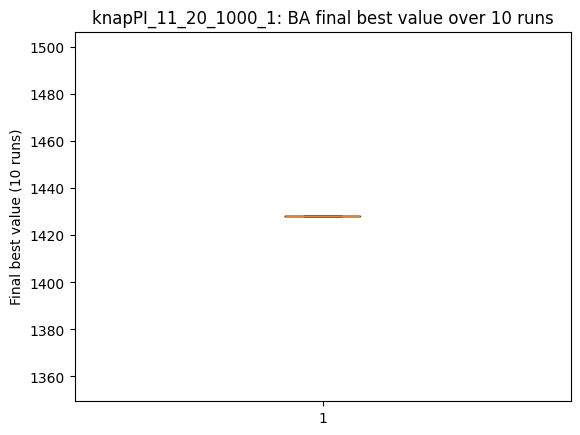

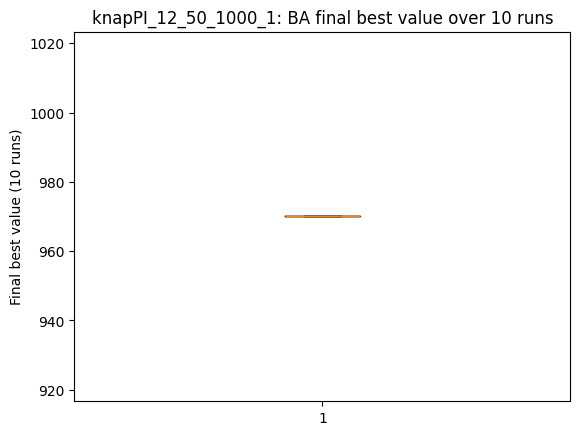

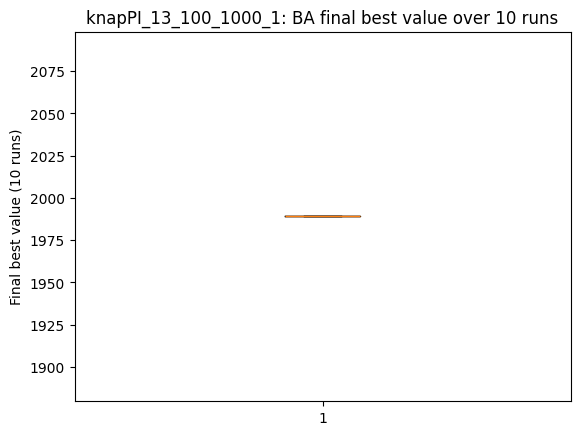

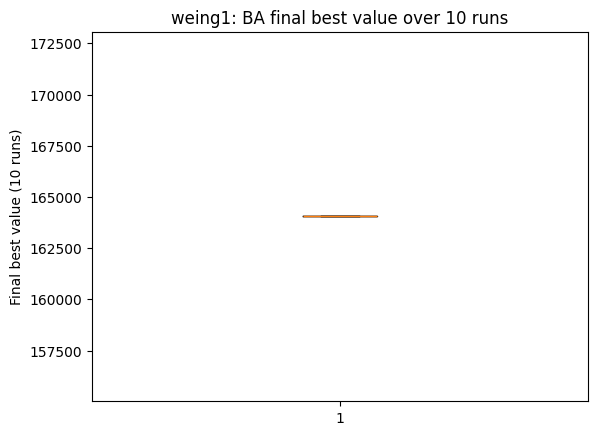

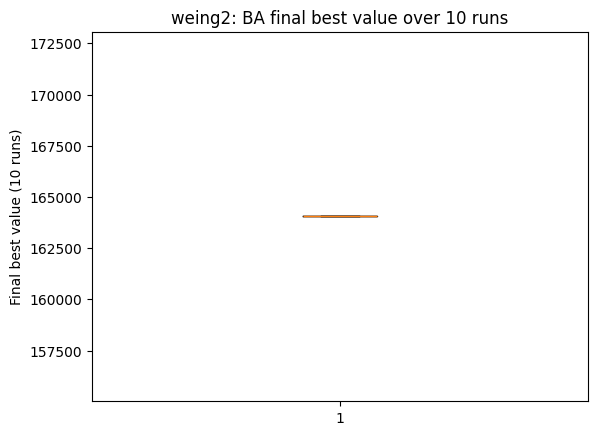

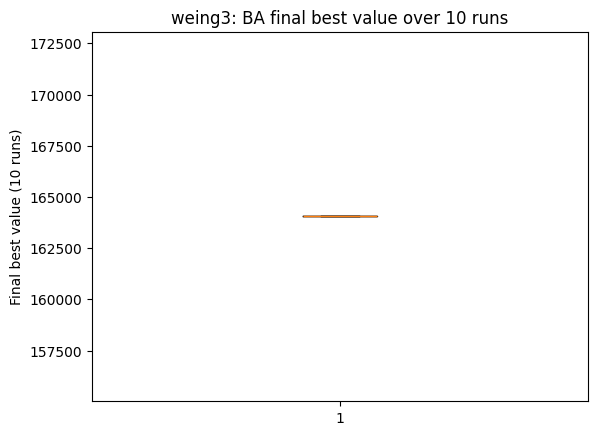

In [19]:
# Boxplots for the 10-run distribution (value)
for inst in instances:
    show_run_boxplot(all_details[inst.name], f"{inst.name}: BA final best value over 10 runs")


In [20]:
def sensitivity_grid(inst: KnapsackInstance, grid: List[Tuple[int,int,int]], seeds=range(10)):
    rows = []
    for nre, nrb, ngh in grid:
        p = dataclasses.replace(ba_params, nre=nre, nrb=nrb, ngh_init=ngh)
        vals = []
        for s in seeds:
            p2 = dataclasses.replace(p, seed=s)
            res, _ = run_ba_on_instance(inst, p2)
            vals.append(res["best_value"])
        rows.append({"nre": nre, "nrb": nrb, "ngh_init": ngh,
                     "mean": np.mean(vals), "std": np.std(vals, ddof=1),
                     "best": np.max(vals), "worst": np.min(vals)})
    return pd.DataFrame(rows)

# Example on a medium instance (use the first Pisinger CSV here)
sens_inst = instances[0]  # e.g., knapPI_11_20_1000_1
grid = [(nre, nrb, ngh) for nre in (10,20,40) for nrb in (5,10,20) for ngh in (2,3,5)]
sens_df = sensitivity_grid(sens_inst, grid)
sens_df.sort_values("mean", ascending=False)


,nre,nrb,ngh_init,mean,std,best,worst
0,10,5,2,1428.0,0.0,1428,1428
1,10,5,3,1428.0,0.0,1428,1428
2,10,5,5,1428.0,0.0,1428,1428
3,10,10,2,1428.0,0.0,1428,1428
4,10,10,3,1428.0,0.0,1428,1428
5,10,10,5,1428.0,0.0,1428,1428
6,10,20,2,1428.0,0.0,1428,1428
7,10,20,3,1428.0,0.0,1428,1428
8,10,20,5,1428.0,0.0,1428,1428
9,20,5,2,1428.0,0.0,1428,1428


In [21]:
def make_report_table(summary_df: pd.DataFrame) -> pd.DataFrame:
    tbl = summary_df.copy()
    tbl["baseline_dp"] = tbl["baseline_dp"].fillna("-")
    cols = ["instance","n","W","ba_best","ba_mean","ba_std","baseline_greedy","baseline_dp","improvement_over_greedy_%"]
    return tbl[cols].sort_values("instance")

report_table = make_report_table(summary_df)
report_table
report_table.to_csv(out_dir/"report_table.csv", index=False)
